<a href="https://colab.research.google.com/github/ericyoc/adversarial-defense-cnn/blob/main/gan_montecarlo_sim_anomaly_detect_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# Set GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Define the generator model
def create_generator():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(100,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(784, activation='tanh')
    ])
    return model

In [4]:
# Define the discriminator model
def create_discriminator():
    model = keras.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [5]:
# Define the GAN model
def create_gan(generator, discriminator):
    discriminator.trainable = False
    model = keras.Sequential([generator, discriminator])
    return model

In [6]:
# Train the GAN
def train_gan(gan, generator, discriminator, x_train, batch_size, num_epochs):
    for epoch in range(num_epochs):
        # Generate random noise as input to the generator
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate fake images using the generator
        generated_images = generator.predict(noise)

        # Combine real and fake images
        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        combined_images = np.concatenate([real_images, generated_images])

        # Create labels for real and fake images
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        labels += 0.05 * np.random.random(labels.shape)

        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_images, labels)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        misleading_targets = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, misleading_targets)

        # Print the progress
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

In [7]:
# Perform anomaly detection
def anomaly_detection(generator, discriminator, x_test):
    # Generate anomaly scores for the test images
    anomaly_scores = discriminator.predict(x_test)
    anomaly_scores = anomaly_scores.flatten()
    return anomaly_scores

In [8]:
# Plot the test images and anomaly detection results
def plot_results(anomaly_image, anomaly_score_anomaly, normal_image, anomaly_score_normal, anomaly_scores, threshold):
    # Plot the anomaly test image
    plt.figure(figsize=(4, 4))
    plt.imshow(anomaly_image.reshape((28, 28)), cmap='gray')
    plt.title(f"Anomaly Test Image (Anomaly Score: {anomaly_score_anomaly:.4f})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot the normal test image
    plt.figure(figsize=(4, 4))
    plt.imshow(normal_image.reshape((28, 28)), cmap='gray')
    plt.title(f"Normal Test Image (Anomaly Score: {anomaly_score_normal:.4f})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot the anomaly scores distribution
    plt.figure(figsize=(8, 4))
    plt.hist(anomaly_scores, bins=20, density=True, alpha=0.7, range=(0, 1))
    plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.title("Anomaly Scores Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
# Print the results summary
def print_results_summary(anomaly_scores, threshold):
    print("Results Summary:")
    print(f"Threshold: {threshold:.4f}")
    print(f"Mean Anomaly Score: {np.mean(anomaly_scores):.4f}")
    print(f"Minimum Anomaly Score: {np.min(anomaly_scores):.4f}")
    print(f"Maximum Anomaly Score: {np.max(anomaly_scores):.4f}")
    print("Anomaly Score Interpretation:")
    print("- Anomaly scores below the threshold indicate anomalous samples.")
    print("- Anomaly scores above the threshold indicate normal samples.")

In [10]:
# Print the test image descriptions
def print_image_descriptions(y_test, anomaly_index, normal_index):
    anomaly_label = y_test[anomaly_index]
    normal_label = y_test[normal_index]
    print("Test Image Descriptions:")
    print(f"Anomaly Test Image: Digit {anomaly_label}")
    print(f"Normal Test Image: Digit {normal_label}")

In [11]:
def main():
    # Load and preprocess the MNIST dataset
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train.reshape((60000, 784)) / 255.0
    x_test = x_test.reshape((10000, 784)) / 255.0

    # Create the generator, discriminator, and GAN models
    with tf.device('/gpu:0'):
        generator = create_generator()
        discriminator = create_discriminator()
        gan = create_gan(generator, discriminator)

        # Compile the models
        optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        gan.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Train the GAN
        batch_size = 128
        num_epochs = 1000
        train_gan(gan, generator, discriminator, x_train, batch_size, num_epochs)

    # Perform anomaly detection
    anomaly_scores = anomaly_detection(generator, discriminator, x_test)

    # Remove any NaN or infinity values from anomaly_scores
    anomaly_scores = anomaly_scores[np.isfinite(anomaly_scores)]

    # Calculate the threshold for anomaly detection
    threshold = np.percentile(anomaly_scores, 95)

    # Select an anomaly test image (anomaly score below the threshold)
    anomaly_indices = np.where(anomaly_scores < threshold)[0]
    if len(anomaly_indices) > 0:
        anomaly_index = anomaly_indices[0]
        anomaly_image = x_test[anomaly_index]
        anomaly_score_anomaly = anomaly_scores[anomaly_index]
    else:
        print("No anomaly test image found.")
        return

    # Select a normal test image (anomaly score above the threshold)
    normal_indices = np.where(anomaly_scores >= threshold)[0]
    if len(normal_indices) > 0:
        normal_index = normal_indices[0]
        normal_image = x_test[normal_index]
        anomaly_score_normal = anomaly_scores[normal_index]
    else:
        print("No normal test image found.")
        return

    # Plot the test images and anomaly detection results
    plot_results(anomaly_image, anomaly_score_anomaly, normal_image, anomaly_score_normal, anomaly_scores, threshold)

    # Print the results summary
    print_results_summary(anomaly_scores, threshold)

    # Print the test image descriptions
    print_image_descriptions(y_test, anomaly_index, normal_index)

4/4 [==============================] - 0s 3ms/step
Epoch: 0, Discriminator Loss: [0.8307802081108093, 0.0], Generator Loss: 0.7759648561477661
4/4 [==============================] - 0s 2ms/step
Epoch: 100, Discriminator Loss: [3.9059510231018066, 0.0], Generator Loss: 0.0012326333671808243
4/4 [==============================] - 0s 2ms/step
Epoch: 200, Discriminator Loss: [4.498129367828369, 0.0], Generator Loss: 0.00029591089696623385
4/4 [==============================] - 0s 2ms/step
Epoch: 300, Discriminator Loss: [4.81445837020874, 0.0], Generator Loss: 0.00016284360026475042
4/4 [==============================] - 0s 2ms/step
Epoch: 400, Discriminator Loss: [5.00303840637207, 0.0], Generator Loss: 0.0001082660528481938
4/4 [==============================] - 0s 2ms/step
Epoch: 500, Discriminator Loss: [5.14275598526001, 0.0], Generator Loss: 7.918682240415365e-05
4/4 [==============================] - 0s 2ms/step
Epoch: 600, Discriminator Loss: [5.229609489440918, 0.0], Generator Los

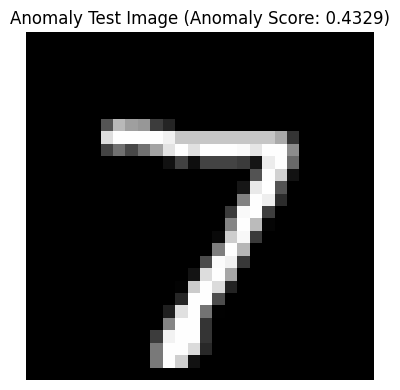

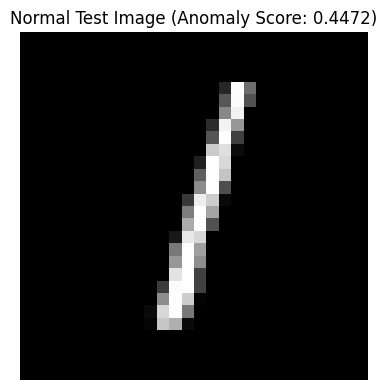

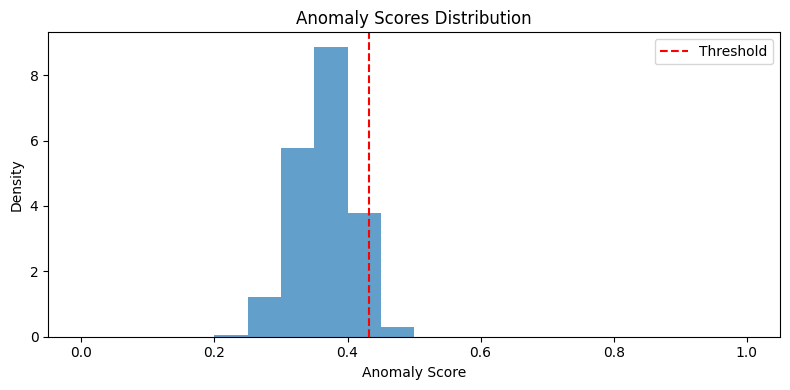

Results Summary:
Threshold: 0.4329
Mean Anomaly Score: 0.3652
Minimum Anomaly Score: 0.2152
Maximum Anomaly Score: 0.4881
Anomaly Score Interpretation:
- Anomaly scores below the threshold indicate anomalous samples.
- Anomaly scores above the threshold indicate normal samples.
Test Image Descriptions:
Anomaly Test Image: Digit 7
Normal Test Image: Digit 1


In [12]:
if __name__ == '__main__':
    main()